In [1]:
import pandas as pd
import os
import numpy as np
import torch
import torch.nn as nn
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification, 
    TrainingArguments, 
    Trainer
)
# ▼▼▼ GroupShuffleSplit をインポート ▼▼▼
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import accelerate
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from tqdm.auto import tqdm

tqdm.pandas()

# CUDAのデバッグ用
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# --- 1. GPUの確認 ---
if torch.cuda.is_available():
    print(f"✅ GPU is available. Device: {torch.cuda.get_device_name(0)}")
    device = torch.device("cuda")
else:
    print("⚠️ GPU not found. Running on CPU.")
    device = torch.device("cpu")

✅ GPU is available. Device: NVIDIA RTX A6000


In [2]:
# --- 2. 設定 (本番用) ---

# ▼▼▼ Hard Negative データセットを使用 ▼▼▼
TRAINING_FILE = "data/processed/training_dataset_hard_negatives_1to3.csv"
MODEL_CHECKPOINT = "allenai/longformer-base-4096"
OUTPUT_MODEL_DIR = "models/cencoder_bce_v1_hard" # Hard Negative版

# --- 実験計画からのハイパーパラメータ ---
MAX_LENGTH = 2048
LEARNING_RATE = 5e-6
EPOCHS = 3
BATCH_SIZE = 32
GRAD_ACCUM_STEPS = 2 # 実質バッチ 64
POS_WEIGHT = 3.0 # ★クラスの重み (1:3比率なので3.0) ★

print(f"Configuration set for PRODUCTION (Hard Negatives, Batch Size: {BATCH_SIZE}, Pos Weight: {POS_WEIGHT})")

Configuration set for PRODUCTION (Hard Negatives, Batch Size: 32, Pos Weight: 3.0)


In [3]:
# --- 3. モデル ---
# C-Encoder (BCE) は、Hugging Face標準の AutoModelForSequenceClassification を
# num_labels=1 でロードすることで実装できます。
print("Model: Standard AutoModelForSequenceClassification (num_labels=1)")

Model: Standard AutoModelForSequenceClassification (num_labels=1)


In [4]:
# --- 4. データロード, GroupSplit, トークナイズ ---
print(f"Loading HARD NEGATIVE dataset: {TRAINING_FILE}")
df_full = pd.read_csv(TRAINING_FILE)
df_full = df_full.dropna(subset=['abstract_a', 'abstract_b', 'label'])

# ▼▼▼ ラベルをBCE用にfloat型に変換 ▼▼▼
df_full['label'] = df_full['label'].astype(float) 
print(f"Full dataset size: {len(df_full)}")

# --- GroupShuffleSplit の実装 ---
print("Performing Group Shuffle Split based on 'abstract_a'...")
groups = df_full['abstract_a'] # Group by the anchor
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(gss.split(df_full, groups=groups))

train_df = df_full.iloc[train_idx]
val_df = df_full.iloc[val_idx]

print(f"Train set: {len(train_df)} pairs")
print(f"Validation set: {len(val_df)} pairs")

# データリーク（重複アンカー）がないか確認
train_anchors = set(train_df['abstract_a'])
val_anchors = set(val_df['abstract_a'])
leakage = train_anchors.intersection(val_anchors)
print(f"Data Leakage Check (Anchor Overlap): {len(leakage)} anchors")
# --- -------------------------- ---

dataset = DatasetDict({
    'train': Dataset.from_pandas(train_df),
    'validation': Dataset.from_pandas(val_df)
})
print(f"Dataset split: {dataset}")

# --- トークナイズ ---
print("Initializing Longformer tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)

# ▼▼▼ 修正点: シンプルなペア用のトークン化 ▼▼▼
def tokenize_nsp_function(examples):
    # 入力: [CLS] abstract_a [SEP] abstract_b [SEP]
    return tokenizer(
        examples["abstract_a"], 
        examples["abstract_b"], 
        padding="max_length", 
        truncation=True, 
        max_length=MAX_LENGTH # 2048
    )

print(f"Tokenizing dataset (max_length={MAX_LENGTH})...")
tokenized_datasets = dataset.map(tokenize_nsp_function, batched=True, num_proc=4)

# ▼▼▼ 修正点: data_paper_doi は df_full に存在しないため削除 ▼▼▼
tokenized_datasets = tokenized_datasets.remove_columns(["abstract_a", "abstract_b"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")
print("Tokenization complete.")

Loading HARD NEGATIVE dataset: data/processed/training_dataset_hard_negatives_1to3.csv
Full dataset size: 28052
Performing Group Shuffle Split based on 'abstract_a'...
Train set: 22044 pairs
Validation set: 6008 pairs
Data Leakage Check (Anchor Overlap): 0 anchors
Dataset split: DatasetDict({
    train: Dataset({
        features: ['abstract_a', 'abstract_b', 'label', 'data_paper_doi', '__index_level_0__'],
        num_rows: 22044
    })
    validation: Dataset({
        features: ['abstract_a', 'abstract_b', 'label', 'data_paper_doi', '__index_level_0__'],
        num_rows: 6008
    })
})
Initializing Longformer tokenizer...


/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Tokenizing dataset (max_length=2048)...


Map (num_proc=4):   0%|          | 0/22044 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/6008 [00:00<?, ? examples/s]

Tokenization complete.


In [5]:
# --- 5. カスタムTrainerの定義 ---
print(f"Setting positive class weight to: {POS_WEIGHT}")
pos_weight_tensor = torch.tensor([POS_WEIGHT])

# 重み付きBCE損失を計算するカスタムTrainerを定義
class CustomBCETrainer(Trainer):
    def __init__(self, *args, pos_weight=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.pos_weight_tensor = pos_weight.to(self.args.device) if pos_weight is not None else None
        self.loss_fct = nn.BCEWithLogitsLoss(pos_weight=self.pos_weight_tensor)
        print(f"CustomBCETrainer initialized with pos_weight={self.pos_weight_tensor}")

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels").view(-1) 
        outputs = model(**inputs)
        logits = outputs.logits.view(-1)
        loss = self.loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

print("Custom 'CustomBCETrainer' defined.")

Setting positive class weight to: 3.0
Custom 'CustomBCETrainer' defined.


In [6]:
# --- 6. モデルのロードと訓練設定 ---
from torch.optim import AdamW # ★オプティマイザをインポート

print(f"Loading model: {MODEL_CHECKPOINT}")
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_CHECKPOINT, 
    num_labels=1 
).to(device)
print("Model loaded.")

# 評価指標を計算する関数 (BCE用)
def compute_metrics_bce(eval_pred):
    logits, labels = eval_pred
    preds = (logits > 0).astype(int)
    labels = labels.astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary', zero_division=0)
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

# クラスの重みを計算
pos_weight_tensor = torch.tensor([POS_WEIGHT])
print(f"Setting positive class weight to: {POS_WEIGHT}")

# 重み付きBCE損失を計算するカスタムTrainerを定義
class CustomBCETrainer(Trainer):
    def __init__(self, *args, pos_weight=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.pos_weight_tensor = pos_weight.to(self.args.device) if pos_weight is not None else None
        self.loss_fct = nn.BCEWithLogitsLoss(pos_weight=self.pos_weight_tensor)
        print(f"CustomBCETrainer initialized with pos_weight={self.pos_weight_tensor}")

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels").view(-1) 
        outputs = model(**inputs)
        logits = outputs.logits.view(-1)
        loss = self.loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

# 訓練の設定
training_args = TrainingArguments(
    output_dir=OUTPUT_MODEL_DIR,
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE, # 32
    per_device_eval_batch_size=BATCH_SIZE,  # 32
    gradient_accumulation_steps=GRAD_ACCUM_STEPS, # 2
    num_train_epochs=EPOCHS, # 3
    weight_decay=0.01,
    
    # ▼▼▼ 修正点: 評価戦略をステップ単位に変更 ▼▼▼
    evaluation_strategy="steps", # "epoch" から "steps" に変更
    eval_steps=50,              # 100ステップごとに検証
    save_strategy="steps",       # 100ステップごとに保存
    save_steps=50,
    
    logging_strategy="steps",
    logging_steps=10,            # 10ステップごとに訓練ロスを記録
    # ▲▲▲ ------------------------------------------ ▲▲▲
    
    load_best_model_at_end=True,
    warmup_ratio=0.1,
    gradient_checkpointing=True, 
)
print("Training arguments set for PRODUCTION (Step-wise Monitoring).")

Loading model: allenai/longformer-base-4096


Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded.
Setting positive class weight to: 3.0
Training arguments set for PRODUCTION (Step-wise Monitoring).


In [7]:
# --- 7. 訓練の開始 ---

# --- 学習率の個別設定 ---
# 1. ベースモデル(Longformer)のパラメータ（学習率: 小）
# (Longformerのベースモデルは 'longformer' という名前で格納されています)
base_model_params = list(model.longformer.named_parameters())

# 2. 分類ヘッド部分のパラメータ（学習率: 大）
classifier_params = list(model.classifier.named_parameters())

# グループ化
optimizer_grouped_parameters = [
    {
        "params": [p for n, p in base_model_params],
        "lr": LEARNING_RATE, # 元の設定 (2e-5)
    },
    {
        "params": [p for n, p in classifier_params],
        "lr": 2e-5, # ★ヘッド部分は大きく (例: 1e-3)
    },
]

# カスタムオプティマイザの作成
optimizer = AdamW(optimizer_grouped_parameters)

# Trainerの初期化 (optimizers引数を使用)
trainer = CustomBCETrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics_bce,
    pos_weight=pos_weight_tensor,
    
    # ▼▼▼ 修正点: カスタムオプティマイザを渡す ▼▼▼
    optimizers=(optimizer, None)
)

print("\n--- Starting Model Training (C-Encoder BCE, Differential Learning Rates) ---")
trainer.train()
print("--- Model Training Complete ---")

Initializing global attention on CLS token...


CustomBCETrainer initialized with pos_weight=tensor([3.], device='cuda:0')

--- Starting Model Training (C-Encoder BCE, Differential Learning Rates) ---


/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,1.047600,1.035051,0.567410,0.364703,0.288142,0.496671
100,1.022900,1.016425,0.498502,0.418676,0.294757,0.722370
150,0.952000,0.967070,0.632656,0.422100,0.347864,0.536618
200,0.868500,0.937758,0.568742,0.450011,0.330321,0.705726
250,0.769200,0.932503,0.578063,0.454956,0.335980,0.704394
300,0.710800,0.921756,0.673768,0.511466,0.408765,0.683089
350,0.682400,0.920293,0.655792,0.515009,0.397538,0.731025
400,0.581900,0.955309,0.653462,0.515589,0.396280,0.737683
450,0.595400,0.981399,0.675100,0.537660,0.417279,0.755659
500,0.570000,1.098304,0.590379,0.498880,0.359343,0.815579


/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning

--- Model Training Complete ---


In [8]:
# --- 8. モデルの保存 ---
import json

print("Training complete. Saving best model...")
best_model_path = os.path.join(OUTPUT_MODEL_DIR, "best_model")
trainer.save_model(best_model_path)
print(f"Model saved to {best_model_path}")

# --- ハイパーパラメータとログも保存 ---
log_history = trainer.state.log_history
df_log = pd.DataFrame(log_history)
log_csv_path = os.path.join(OUTPUT_MODEL_DIR, "training_logs.csv")
df_log.to_csv(log_csv_path, index=False)
print(f"Training logs (CSV) saved to {log_csv_path}")

args_json_path = os.path.join(OUTPUT_MODEL_DIR, "training_args.json")
with open(args_json_path, "w") as f:
    json.dump(trainer.args.to_dict(), f, indent=2)
print(f"Hyperparameters (JSON) saved to {args_json_path}")

Training complete. Saving best model...
Model saved to models/cencoder_bce_v1_hard/best_model
Training logs (CSV) saved to models/cencoder_bce_v1_hard/training_logs.csv
Hyperparameters (JSON) saved to models/cencoder_bce_v1_hard/training_args.json



--- Visualizing Training Results ---


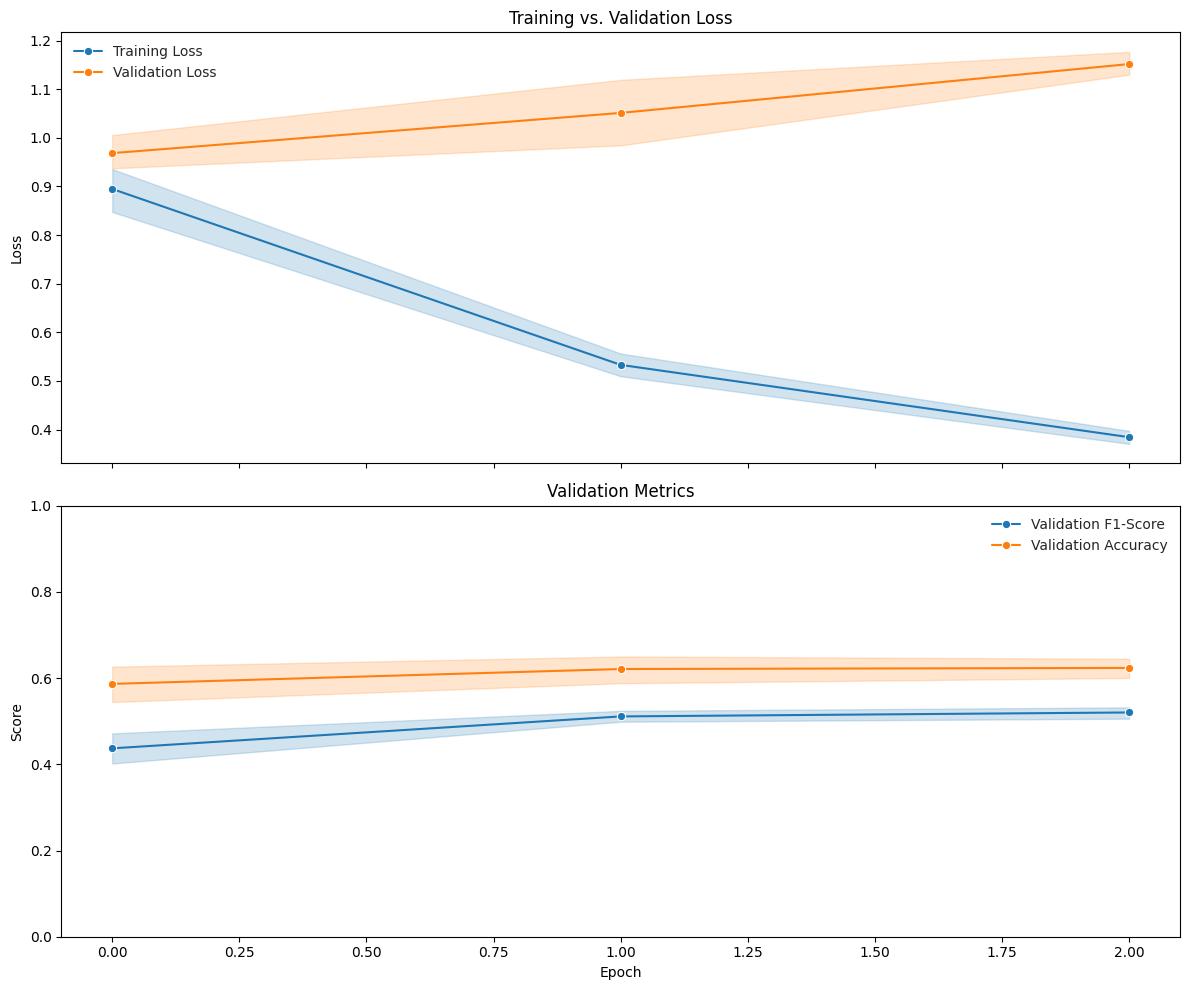


--- Best Model Evaluation Metrics (from validation set) ---
Best Epoch (based on min eval_loss): 1.0
Best Validation Loss: 0.9203
Best Validation F1: 0.5150
Best Validation Accuracy: 0.6558


In [9]:
# --- 9. 訓練結果の可視化 ---
print("\n--- Visualizing Training Results ---")
# (df_log は セル 8 で定義済み)

df_train = df_log[df_log['loss'].notna()].copy()
df_eval = df_log[df_log['eval_loss'].notna()].copy()

if 'epoch' in df_train.columns:
    df_train['epoch'] = df_train['epoch'].astype(int)
if 'epoch' in df_eval.columns:
    df_eval['epoch'] = df_eval['epoch'].astype(int)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
plt.style.use('seaborn-v0_8-whitegrid')

if not df_train.empty:
    sns.lineplot(data=df_train, x='epoch', y='loss', label='Training Loss', ax=ax1, marker='o')
if not df_eval.empty:
    sns.lineplot(data=df_eval, x='epoch', y='eval_loss', label='Validation Loss', ax=ax1, marker='o')
ax1.set_title('Training vs. Validation Loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.legend()

if not df_eval.empty:
    sns.lineplot(data=df_eval, x='epoch', y='eval_f1', label='Validation F1-Score', ax=ax2, marker='o')
    sns.lineplot(data=df_eval, x='epoch', y='eval_accuracy', label='Validation Accuracy', ax=ax2, marker='o')
ax2.set_title('Validation Metrics')
ax2.set_ylabel('Score')
ax2.set_xlabel('Epoch')
ax2.legend()
ax2.set_ylim(0, 1)

plt.tight_layout()
plt.show()

print("\n--- Best Model Evaluation Metrics (from validation set) ---")
if not df_eval.empty:
    best_run = df_eval.loc[df_eval['eval_loss'].idxmin()]
    print(f"Best Epoch (based on min eval_loss): {best_run['epoch']}")
    print(f"Best Validation Loss: {best_run['eval_loss']:.4f}")
    print(f"Best Validation F1: {best_run['eval_f1']:.4f}")
    print(f"Best Validation Accuracy: {best_run['eval_accuracy']:.4f}")
else:
    print("No evaluation steps were completed.")